Implementation of Pix2Pix paper for using the UNet encoder-decoder generator for the features -> facades task.

Dataset obtained from: https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/

## [Paper](https://arxiv.org/abs/1611.07004)

## Imports

In [1]:
import os
import time
import random

import torch
import torchvision
import numpy as np
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
from sklearn.metrics import accuracy_score
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid, save_image


# Fix random seed
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Using {device}")

Using cuda:0


## Dataset

Download data from official site, define transforms and load images.



In [2]:
! wget https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz
! tar -xf "facades.tar.gz" 

--2021-02-19 23:04:44--  https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30168306 (29M) [application/x-gzip]
Saving to: ‘facades.tar.gz’

facades.tar.gz      100%[===================>]  28.77M  1.10MB/s    in 14s     

2021-02-19 23:04:59 (2.09 MB/s) - ‘facades.tar.gz’ saved [30168306/30168306]



In [3]:
class ImagePairsDataset(Dataset):
    """
    Load images from specified folder.
    Applies the resize -> RandomCrop jitter transformation to each image in the pair (aligned)
    Images are input-target concatenated and should be split at the halfway point.

    Forced to fix the transform and use transforms.functional
    since there's no other way of performing the exact same
    random crop over two images (input and target)
    """

    def __init__(
        self,
        images_path,
        jitter_aug=True,
        left_image_input=True,
        image_pair_size=(256, 512),
        target_image_size=(256, 256),
        expanded_image_size=(286, 286),
    ):
        super(ImagePairsDataset, self).__init__()

        self.images_folder = images_path
        self.image_height = image_pair_size[0]
        self.image_width = image_pair_size[1]

        self.left_image_input = left_image_input
        self.jitter_aug = jitter_aug
        self.target_image_size = target_image_size
        self.expanded_image_size = expanded_image_size

        self.all_image_paths = [
            os.path.join(self.images_folder, current_image)
            for current_image in os.listdir(self.images_folder)
        ]

    def __len__(self):
        return len(self.all_image_paths)

    def __getitem__(self, idx):
        img_path = self.all_image_paths[idx]

        full_image = Image.open(img_path)

        input_image, target_image = self.__get_input_target_image(full_image)

        if self.jitter_aug:
            input_image, target_image = self.__perform_jitter_aug(
                input_image, target_image
            )
        return TF.to_tensor(input_image), TF.to_tensor(target_image)

    def __get_input_target_image(self, complete_image):
        img_left_area = (0, 0, self.image_width // 2, self.image_height)
        img_right_area = (self.image_width // 2, 0, self.image_width, self.image_height)

        left_image = complete_image.crop(img_left_area)
        right_image = complete_image.crop(img_right_area)

        if self.left_image_input:
            return left_image, right_image

        return right_image, left_image

    def __perform_jitter_aug(self, input_img, target_img):
        # Expand and random crop
        resize = transforms.Resize(size=self.expanded_image_size)
        input_img = resize(input_img)
        target_img = resize(target_img)

        crop_params = transforms.RandomCrop.get_params(
            input_img, output_size=self.target_image_size
        )

        input_img = TF.crop(input_img, *crop_params)
        target_img = TF.crop(target_img, *crop_params)

        # Random mirroring (vertical/horizontal flip)
        if random.random() > 0.5:
            input_img = TF.hflip(input_img)
            target_img = TF.hflip(target_img)
        if random.random() > 0.5:
            input_img = TF.vflip(input_img)
            target_img = TF.vflip(target_img)
        return input_img, target_img


## Models

### Generator


In [4]:
class UNetBlock(nn.Module):
    """
    U-Net block:
      performs downsampling -> | submodule | -> upsample
      and the skip connection between the downsampling and upsampling layers
    """

    def __init__(
        self,
        output_channels,
        num_filters,
        input_channels=None,
        submodule=None,
        outermost=False,
        innermost=False,
        dropout=None,
    ):
        """
        Parameters
        ----------
        output_channels: int
          Number of filter in the outer convolution layer.
        num_filters: int
          Number of filter in the inner convolution layer.
        input_channels: int
          Number of channels from the input image/activation maps
        submodule: nn.Module
          Submodule to run after downsampling and before upsampling
         outermost: bool
          Whether the block is the outermost one
        innermost: bool
          Whether the block is the innermost one
        dropout: float
          Dropout probability to apply to the module, defualts to None
        """
        super(UNetBlock, self).__init__()
        self.outermost = outermost

        if not input_channels:
          input_channels = output_channels

        down_module = self._get_downsampling_module(
            input_channels, num_filters, outermost, innermost
        )
        up_module = self._get_upsampling_module(
            num_filters, output_channels, outermost, innermost
        )

        if submodule:
          modules = down_module + [submodule] + up_module
        else:
          modules = down_module + up_module

        if dropout:
            modules = modules + [nn.Dropout(dropout)]
            
        self.model = nn.Sequential(*modules)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            # skip connections
            return torch.cat([x, self.model(x)], 1)

    def _get_downsampling_module(
        self, input_channels, num_filters, outermost, innermost
    ):
        conv = nn.Conv2d(
            in_channels=input_channels,
            out_channels=num_filters,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=False,
        )

        if outermost:
            modules = [conv]
        elif innermost:
            modules = [nn.LeakyReLU(0.2), conv]
        else:
            modules = [nn.LeakyReLU(0.2), conv, nn.BatchNorm2d(num_filters)]
        return modules

    def _get_upsampling_module(
        self, num_filters, output_channels, outermost, innermost
    ):
        up_input_channels = num_filters if innermost else num_filters * 2
        activation = nn.ReLU()

        conv = nn.ConvTranspose2d(
            in_channels=up_input_channels,
            out_channels=output_channels,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=outermost,
        )

        if outermost:
          modules = [activation, conv, nn.Tanh()]
        else:
          modules= [activation, conv, nn.BatchNorm2d(output_channels)]

        return modules


In [5]:
class UNetGenerator(nn.Module):
    """
    UNet (Encoder - Decoder) architecture for the generator,
    decomposes input image into a latent representation
    and builds output based on it using skip connections between layers.
    """

    def __init__(self, input_channels, output_channels):
        super(UNetGenerator, self).__init__()

        # Paper specification: C64-C128-C256-C512-C512-C512-C512-C512
        # Start building from the inside out
        u_net_block = UNetBlock(output_channels=512, num_filters=512, innermost=True)
        u_net_block = UNetBlock(output_channels=512, num_filters=512, submodule=u_net_block, dropout=0.5)
        u_net_block = UNetBlock(output_channels=512, num_filters=512, submodule=u_net_block, dropout=0.5)
        u_net_block = UNetBlock(output_channels=512, num_filters=512, submodule=u_net_block, dropout=0.5)
        u_net_block = UNetBlock(output_channels=256, num_filters=512, submodule=u_net_block)
        u_net_block = UNetBlock(output_channels=128, num_filters=256, submodule=u_net_block)
        u_net_block = UNetBlock(output_channels=64, num_filters=128, submodule=u_net_block)

        self.model = UNetBlock(input_channels=input_channels, num_filters=64, output_channels=output_channels, outermost=True, submodule=u_net_block)

    def forward(self, x):
      return self.model(x)


### Discriminator

In [6]:
class DiscConvBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        stride=2,
        leaky_slope=0.2,
        normalization=True,
        bias=False,
    ):
        super(DiscConvBlock, self).__init__()
        modules = []
        modules.append(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=4,
                stride=stride,
                padding=1,
                bias=bias,
            )
        )

        if normalization:
            modules.append(nn.BatchNorm2d(out_channels))

        modules.append(nn.LeakyReLU(leaky_slope))

        self.model = nn.Sequential(*modules)

    def forward(self, x):
        return self.model(x)


In [7]:
class DiscriminatorModel(nn.Module):
    """
    Paper specification: C64-C128-C256-C512-C512-C512
    + final convolution to map output to 1-dimension
     (Sigmoid call handled by loss function).

    This is a simpler discriminator as used by the authors on their available code,
    as the complex one was too powerful and would cause the generator to collapse:
    C64-C128-C256-C512.
    """

    def __init__(self, in_channels=3):
        super(DiscriminatorModel, self).__init__()

        self.model = nn.Sequential(
            DiscConvBlock(in_channels, out_channels=64, normalization=False, leaky_slope=0.2, bias=True),
            DiscConvBlock(in_channels=64, out_channels=128, leaky_slope=0.2),
            DiscConvBlock(in_channels=128, out_channels=256, leaky_slope=0.2),
            DiscConvBlock(in_channels=256, out_channels=512, leaky_slope=0.2, stride=1),
            nn.Conv2d(
                in_channels=512, out_channels=1, kernel_size=4, padding=1, stride=1
            ),
        )

    def forward(self, x):
        return self.model(x)


## Training

In [8]:
def single_adversarial_epoch(
    generator,
    discriminator,
    gen_optim,
    disc_optim,
    dataloader,
    adversarial_loss,
    reconstruction_loss,
    reconstruction_weight=100,
):
    gen_loss = 0
    rec_loss = 0
    disc_loss_real = 0
    disc_loss_generated = 0

    for input_images, target_images in dataloader:
        ##  Train Discriminator ##
        disc_optim.zero_grad()

        # All-real batch
        disc_real_input = torch.cat([input_images, target_images], dim=1)
        real_predictions = discriminator(disc_real_input.to(device))
        disc_real_cost = adversarial_loss(
            real_predictions,
            torch.ones_like(real_predictions).to(device),
        )
        disc_loss_real += disc_real_cost.item()

        # All-generated batch
        gen_images = generator(input_images.to(device))
        disc_gen_input = torch.cat([gen_images, target_images.to(device)], dim=1)
        generated_data_predictions = discriminator(disc_gen_input)
        disc_generated_cost = adversarial_loss(
            generated_data_predictions,
            torch.zeros_like(generated_data_predictions).to(device),
        )
        disc_loss_generated += disc_generated_cost.item()

        disc_total_cost = (disc_real_cost + disc_generated_cost) / 2
        disc_total_cost.backward()
        disc_optim.step()

        ## Train Generator ##
        gen_optim.zero_grad()
        gen_images = generator(input_images.to(device))

        # Measure ability of generator to FOOL discriminator
        disc_gen_input = torch.cat([gen_images, target_images.to(device)], dim=1)
        generated_data_predictions = discriminator(disc_gen_input)
        gen_cost = adversarial_loss(
            generated_data_predictions,
            torch.ones_like(generated_data_predictions).to(device),
        )
        gen_loss += gen_cost.item()

        # Measure reconstruction loss
        gen_reconstruction_cost = reconstruction_loss(
            gen_images, target_images.to(device)
        )
        rec_loss += gen_reconstruction_cost.item()

        total_gen_cost = gen_cost + reconstruction_weight * gen_reconstruction_cost
        total_gen_cost.backward()
        gen_optim.step()

    return (
        gen_loss / len(dataloader),
        rec_loss / len(dataloader),
        disc_loss_real / len(dataloader),
        disc_loss_generated / len(dataloader),
    )


In [9]:
def adversarial_train(
    generator,
    discriminator,
    gen_optim,
    disc_optim,
    train_dataloader,
    val_dataloader,
    epochs=50,
):  
    adversarial_loss = nn.BCEWithLogitsLoss().to(device)
    reconstruction_loss = nn.L1Loss().to(device)

    gen_losses = []
    rec_losses = []
    disc_valid_losses = []
    disc_generated_losses = []

    for current_epoch in range(epochs):
        start = time.time()
        generator.train()

        (
            gen_loss,
            rec_loss,
            disc_valid_loss,
            disc_gen_loss,
        ) = single_adversarial_epoch(
            generator,
            discriminator,
            gen_optim,
            disc_optim,
            train_dataloader,
            adversarial_loss,
            reconstruction_loss,
        )

        gen_losses.append(gen_loss)
        rec_losses.append(rec_loss)
        disc_valid_losses.append(disc_valid_loss)
        disc_generated_losses.append(disc_gen_loss)

        # Sample images and save result.
        with torch.no_grad():
          generator.eval()
          test_images, test_target_images = next(iter(val_dataloader))  
          gen_images = generator(test_images.to(device))
          grid = make_grid(torch.cat([gen_images, test_images.to(device)], dim=2))
          save_image(grid, f"sample_data/{current_epoch + 1}.png")

        print(
            f"Epoch {current_epoch + 1} | "
            f"Gen Loss {gen_loss:.6f} | "
            f"Reconstruction Loss {rec_loss:.6f} | "
            f"Disc Generated Loss {disc_gen_loss:.6f} | "
            f"Disc Valid Loss {disc_valid_loss:.6f}| "
            f"Time {(time.time() - start):.2f} sec"
        )
    return gen_losses, rec_losses, disc_generated_losses, disc_valid_losses


In [10]:
def init_weights(m):
    if type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0.0)


## Results

In [11]:
train_images = ImagePairsDataset("facades/train", left_image_input=False)
val_images = ImagePairsDataset("facades/val", left_image_input=False, jitter_aug=False)

train_dataloader = DataLoader(
    train_images, batch_size=1, num_workers=8, pin_memory=True
)
val_dataloader = DataLoader(val_images, batch_size=5, num_workers=8, pin_memory=True)

# Define models
generator = UNetGenerator(input_channels=3, output_channels=3).to(device)
# Discriminator has 6 input channels since we feed both x and y to it
discriminator = DiscriminatorModel(in_channels=6).to(device)

# Initialize weights
generator.apply(init_weights)
discriminator.apply(init_weights)

# Optimizers
gen_optim = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
disc_optim = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


Epoch 1 | Gen Loss 5.177534 | Reconstruction Loss 0.202369 | Disc Generated Loss 0.072657 | Disc Valid Loss 0.072796| Time 59.43 sec
Epoch 2 | Gen Loss 7.896231 | Reconstruction Loss 0.182565 | Disc Generated Loss 0.000808 | Disc Valid Loss 0.000683| Time 61.27 sec
Epoch 3 | Gen Loss 6.288590 | Reconstruction Loss 0.188134 | Disc Generated Loss 0.036523 | Disc Valid Loss 0.031273| Time 61.17 sec
Epoch 4 | Gen Loss 8.048023 | Reconstruction Loss 0.175506 | Disc Generated Loss 0.000976 | Disc Valid Loss 0.000917| Time 61.29 sec
Epoch 5 | Gen Loss 8.654901 | Reconstruction Loss 0.168950 | Disc Generated Loss 0.000248 | Disc Valid Loss 0.000232| Time 61.25 sec
Epoch 6 | Gen Loss 8.855795 | Reconstruction Loss 0.167326 | Disc Generated Loss 0.000168 | Disc Valid Loss 0.000121| Time 61.26 sec
Epoch 7 | Gen Loss 8.922989 | Reconstruction Loss 0.167172 | Disc Generated Loss 0.026289 | Disc Valid Loss 0.009760| Time 61.31 sec
Epoch 8 | Gen Loss 6.202647 | Reconstruction Loss 0.195799 | Disc Gen

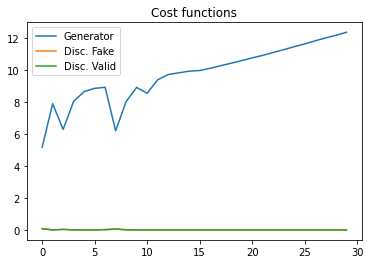

In [12]:
N_EPOCHS = 30

(
    gen_losses,
    rec_losses,
    disc_fake_losses,
    disc_valid_losses,
) = adversarial_train(
    generator,
    discriminator,
    gen_optim,
    disc_optim,
    train_dataloader,
    val_dataloader,
    epochs=N_EPOCHS,
)

plt.plot(range(N_EPOCHS), gen_losses, label="Generator")
plt.plot(range(N_EPOCHS), disc_fake_losses, label="Disc. Fake")
plt.plot(range(N_EPOCHS), disc_valid_losses, label="Disc. Valid")
plt.legend()
plt.title("Cost functions")
plt.show()


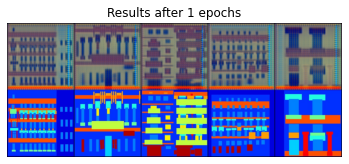

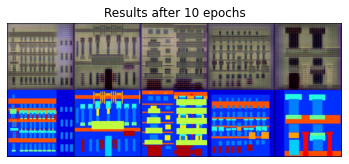

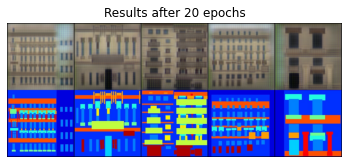

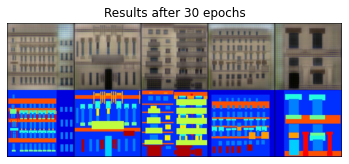

In [13]:
image = Image.open(f"sample_data/1.png")
plt.imshow(image)
plt.title(f"Results after 1 epochs")
plt.axis("off")
plt.show()

for i in range(10, N_EPOCHS + 1, 10):
    image = Image.open(f"sample_data/{i}.png")
    plt.imshow(image)
    plt.title(f"Results after {i} epochs")
    plt.axis("off")
    plt.show()